# 6支持向量机
上来就要啃硬骨头，支持向量机，机器学习算法的巅峰之作。

**SVM的一般流程**
1. 收集数据
2. 准备数据：数值型数据
3. 分析数据：有助于可视化分隔超平面
4. 训练算法：SVM的大部分时间都源自训练，该过程主要实现两个参数的参数调优
5. 测试算法
6. 使用算法：可用于所有分类问题。对于多分类问题需要修改代码

## 6.1SMO简化版
简化了选择变量的步骤，直接遍历+随机分别选取两个alpha。

1996年，John Platt发布了SMO（Sequential Minimal Optimization）算法用于训练SVM。
目标：求出alpha和b，计算权重向量w得到分隔超平面。
工作原理：每次循环中选择两个alpha进行优化处理。一旦找到满足两个条件（条件一，两个alpha必须在间隔边界之外；条件二，两个alpha还没有进行过区间化处理或者不在边界上）的alpha，就增大其中一个，减小另一个。

参考阅读：
1. [random.uniform](https://docs.python.org/3/library/random.html#real-valued-distributions)

In [13]:
import random
def loadDataSet(filename):
    dataMat, labelMat = [], []
    fr = open(filename)
    for line in fr.readlines():
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat, labelMat

def selectJrand(i, m):
    j = i
    while (j==i):
        j = int(random.uniform(0,m))
    return j

def clipAlpha(aj, H, L):
    if aj < L:aj=L
    elif aj > H:aj = H
    return aj

算法流程：
创建一个alpha向量并将其初始化为0向量
当迭代次数小于最大迭代次数时（外循环）
    对数据集中的每个数据向量（内循环）：
        如果该数据向量可以被优化：
            随机选择另外一个数据向量
            同时优化这两个向量
            如果两个向量都不能被优化，退出内循环
    如果所有向量没都被优化，增加迭代数目，继续下一次循环

参考阅读：
1. [np.array()和np.mat()区别](http://www.mamicode.com/info-detail-2664838.html)


In [37]:
import numpy as np
from numpy import mat,multiply
def smoSimple(dataMatIn, classLabels, C, toler, maxIter):
    dataMatrix, labelMat = mat(dataMatIn), mat(classLabels).transpose()
    b = 0
    m, n = np.shape(dataMatrix)
    alphas = mat(np.zeros((m,1)))
    iter = 0
    while iter < maxIter:
        alphaPairsChanged = 0
        for i in range(m):
            fXi = float(multiply(alphas, labelMat).T * (dataMatrix*dataMatrix[i,:].T)) + b
            Ei = fXi - float(labelMat[i])
            #1.如果alpha可以更改，进入优化过程
            if (labelMat[i]*Ei < -toler) and (alphas[i] < C) or ((labelMat[i]*Ei > toler) and (alphas[i] > 0)):
                #2.随机选择第二个alpha
                j = selectJrand(i, m)
                fXj = float(multiply(alphas, labelMat).T * (dataMatrix*dataMatrix[j,:].T)) + b
                Ej = fXj - float(labelMat[j])
                alphaIold = alphas[i].copy()
                alphaJold = alphas[j].copy()
                #3.保证alpha在0和C之间
                if (labelMat[i] != labelMat[j]):
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                if L==H:
                    print("L==H")
                    continue
                eta = 2.0 * dataMatrix[i,:] * dataMatrix[j,:].T - dataMatrix[i,:] * dataMatrix[i,:].T - dataMatrix[j,:]*dataMatrix[j,:].T
                if eta >= 0:
                    print("eta>=0")
                    continue
                #4. 对i进行修改，修改量与j相同，但方向相反
                alphas[j] -= labelMat[j]*(Ei-Ej)/eta
                alphas[j] = clipAlpha(alphas[j], H, L)
                if (abs(alphas[j] - alphaJold) < 0.00001):
                    print("j not moving enough")
                    continue
                alphas[i] += labelMat[j]*labelMat[i]*(alphaJold - alphas[j])
                b1 = b - Ei - labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[i,:].T - \
                labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[i,:]*dataMatrix[j,:].T
                b2 = b - Ej - labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i]*dataMatrix[j,:].T - \
                labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[j]*dataMatrix[j,:].T
                # 5.设置常规项
                if 0<alphas[i] and C>alphas[i]:b = b1
                elif 0<alphas[j] and C>alphas[j]:b = b2
                alphaPairsChanged += 1
                print("iter:%d i: %d, pairs changed %d" % (iter, i, alphaPairsChanged))
        if alphaPairsChanged == 0: iter += 1
        else: iter = 0
        print("iteration number: %d" % iter)
    return b, alphas
dataArr, labelArr = loadDataSet('testSet.txt')
b, alphas = smoSimple(dataArr, labelArr, 0.6, 0.001, 40)

iter:0 i: 0, pairs changed 1
L==H
j not moving enough
L==H
L==H
L==H
iter:0 i: 17, pairs changed 2
L==H
j not moving enough
j not moving enough
L==H
L==H
L==H
L==H
L==H
L==H
j not moving enough
L==H
iteration number: 0
iter:0 i: 0, pairs changed 1
j not moving enough
L==H
j not moving enough
j not moving enough
L==H
L==H
j not moving enough
j not moving enough
L==H
L==H
L==H
j not moving enough
L==H
j not moving enough
L==H
iteration number: 0
L==H
j not moving enough
j not moving enough
iter:0 i: 17, pairs changed 1
j not moving enough
j not moving enough
L==H
L==H
iter:0 i: 46, pairs changed 2
L==H
j not moving enough
j not moving enough
j not moving enough
L==H
iter:0 i: 97, pairs changed 3
iteration number: 0
iter:0 i: 0, pairs changed 1
j not moving enough
iter:0 i: 15, pairs changed 2
j not moving enough
L==H
j not moving enough
iter:0 i: 23, pairs changed 3
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iter:0 i: 52, pairs cha

iteration number: 4
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 5
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 6
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 7
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 8
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough


j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 8
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 9
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 10
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 11
j not moving enough
j not moving enough
j not moving enough
j not moving enoug

j not moving enough
j not moving enough
j not moving enough
iteration number: 14
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 15
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 16
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 17
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 18
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 19
j not moving enough
j not moving enough
j not moving enough
iteration number: 20
j not moving enough
j not moving enough
j not moving enough
iteration number: 21
iter:21 i: 17, pairs changed 1
j not moving enough
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
i

j not moving enough
j not moving enough
j not moving enough
iteration number: 5
j not moving enough
j not moving enough
j not moving enough
iteration number: 6
j not moving enough
j not moving enough
j not moving enough
iteration number: 7
j not moving enough
j not moving enough
j not moving enough
iteration number: 8
j not moving enough
j not moving enough
j not moving enough
iteration number: 9
j not moving enough
iter:9 i: 52, pairs changed 1
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
iter:2 i: 17, pairs changed 1
j not moving enough
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
j not moving enough
iteration number: 3


j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 3
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough


iteration number: 2
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 3
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 4
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 5
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 6
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 7
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 8
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 9
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 10

iteration number: 29
j not moving enough
j not moving enough
j not moving enough
iteration number: 30
j not moving enough
j not moving enough
j not moving enough
iteration number: 31
j not moving enough
j not moving enough
j not moving enough
iteration number: 32
j not moving enough
j not moving enough
j not moving enough
iteration number: 33
j not moving enough
j not moving enough
j not moving enough
iteration number: 34
j not moving enough
j not moving enough
j not moving enough
iteration number: 35
j not moving enough
j not moving enough
j not moving enough
iteration number: 36
j not moving enough
j not moving enough
j not moving enough
iteration number: 37
j not moving enough
j not moving enough
j not moving enough
iteration number: 38
j not moving enough
j not moving enough
j not moving enough
iteration number: 39
j not moving enough
j not moving enough
j not moving enough
iteration number: 40


In [39]:
b

matrix([[-3.79946393]])

In [44]:
print(alphas[alphas>0])
print(shape(alphas[alphas>0]))

[[1.28978378e-01 2.38457654e-01 1.73472348e-18 3.67436032e-01]]
(1, 4)


In [46]:
#打印支持向量
for i in range(100):
    if alphas[i]>0.0:
        print(dataArr[i],labelArr[i])

[4.658191, 3.507396] -1.0
[3.457096, -0.082216] -1.0
[2.893743, -1.643468] -1.0
[6.080573, 0.418886] 1.0


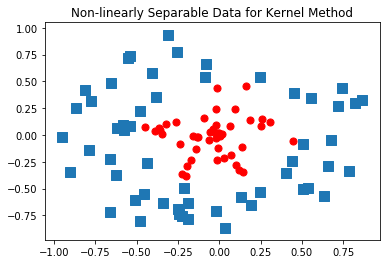

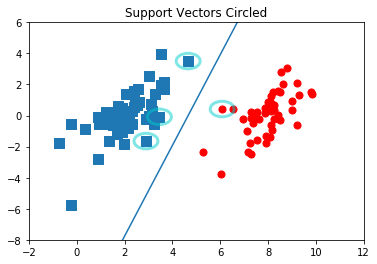

In [60]:
#可视化4个支持向量
%matplotlib inline
%run EXTRAS/plotRBF.py
%run EXTRAS/plotSupportVectors.py